# Predicting Bundesliga Match Results

In this project, we'll use Bundesliga match logs to build a model aimed at predicting the winner of a match. We have scraped data from [https://fbref.com](https://fbref.com) and created a csv file in a separate notebook (refer to get_data.ipynb).

Our data spans six full seasons. We'll compare the performances of random forest, ridge and support vector classifiers from sklearn and xgboost classifier on our data set.

## Cleaning the data set

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer, confusion_matrix, RocCurveDisplay
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('match_data.csv', index_col=0)
df.shape

(3672, 39)

In [3]:
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
1,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,4.0,...,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
2,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,...,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
3,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,...,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
4,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,2.8,...,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
6,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,...,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


In [4]:
# Check if there are any missing matches
df['round'].value_counts().sort_values()

round
Matchweek 1     108
Matchweek 4     108
Matchweek 5     108
Matchweek 6     108
Matchweek 7     108
Matchweek 8     108
Matchweek 9     108
Matchweek 10    108
Matchweek 11    108
Matchweek 12    108
Matchweek 13    108
Matchweek 14    108
Matchweek 15    108
Matchweek 16    108
Matchweek 17    108
Matchweek 18    108
Matchweek 19    108
Matchweek 33    108
Matchweek 26    108
Matchweek 20    108
Matchweek 21    108
Matchweek 22    108
Matchweek 23    108
Matchweek 24    108
Matchweek 3     108
Matchweek 25    108
Matchweek 2     108
Matchweek 28    108
Matchweek 29    108
Matchweek 30    108
Matchweek 31    108
Matchweek 32    108
Matchweek 27    108
Matchweek 34    108
Name: count, dtype: int64

We'll sort our data set by date and time of matches to facilitate the implementation of time series cross-validation in subsequent steps.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df = df.copy().sort_values(['date', 'time']).reset_index(drop=True)

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,2017-08-18,20:30,Matchweek 1,Fri,Home,W,3,1,Leverkusen,2.6,1.6,52.0,75000.0,Thomas Müller,4-3-3,Tobias Stieler,12.0,7.0,16.9,0.0,1.0,1.0,4.0,3.0,0.0,0.0,459.0,547.0,9407.0,3624.0,483.0,59.0,0.0,8.0,14.0,22.0,4.0,2017-2018,Bayern Munich
1,2017-08-18,20:30,Matchweek 1,Fri,Away,L,1,3,Bayern Munich,1.6,2.6,48.0,75000.0,Bernd Leno,4-2-3-1,Tobias Stieler,19.0,4.0,17.8,1.0,0.0,0.0,8.0,5.0,1.0,0.0,437.0,515.0,7391.0,2588.0,468.0,46.0,5.0,4.0,10.0,12.0,5.0,2017-2018,Bayer Leverkusen
2,2017-08-19,15:30,Matchweek 1,Sat,Home,W,1,0,Werder Bremen,1.0,0.9,64.0,30150.0,Kevin Vogt,3-1-4-2,Guido Winkmann,14.0,3.0,23.4,1.0,0.0,0.0,2.0,2.0,0.0,0.0,561.0,666.0,10135.0,3589.0,612.0,51.0,1.0,0.0,20.0,24.0,6.0,2017-2018,Hoffenheim
3,2017-08-19,15:30,Matchweek 1,Sat,Away,W,3,0,Wolfsburg,1.0,0.4,69.0,30000.0,Sokratis Papastathopoulos,4-3-3,Robert Hartmann,13.0,5.0,19.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.0,697.0,10637.0,3830.0,640.0,57.0,0.0,3.0,13.0,33.0,5.0,2017-2018,Dortmund
4,2017-08-19,15:30,Matchweek 1,Sat,Away,L,0,2,Hertha BSC,1.0,0.5,47.0,44751.0,Christian Gentner,4-4-2,Sascha Stegemann,8.0,2.0,17.3,1.0,0.0,0.0,4.0,2.0,0.0,0.0,388.0,491.0,6661.0,2278.0,437.0,51.0,0.0,2.0,12.0,23.0,1.0,2017-2018,Stuttgart


There are inconsistencies in the team names in `team` and `opponent` columns; below we look at the different occurences of the same team, and standardize the names.

In [8]:
team_set = set(df['team'].unique())
opp_set = set(df['opponent'].unique())

# Examine the symmetric difference between two sets to identify any inconsistencies
(team_set - opp_set) | (opp_set - team_set)


{'Bayer Leverkusen',
 'Dusseldorf',
 'Düsseldorf',
 'Eint Frankfurt',
 'Eintracht Frankfurt',
 'Greuther Furth',
 'Greuther Fürth',
 'Koln',
 'Köln',
 'Leverkusen',
 "M'Gladbach",
 'Monchengladbach',
 'Nurnberg',
 'Nürnberg'}

In [9]:
map_values = {
    'Koln':'Köln',
    'Leverkusen': 'Bayer Leverkusen',
    'Dusseldorf': 'Düsseldorf',
    'Eint Frankfurt': 'Eintracht Frankfurt',
    'Greuther Furth': 'Greuther Fürth',
    "M'Gladbach": 'Monchengladbach',
    'Nurnberg': 'Nürnberg'
}

df.replace({'team':map_values, 'opponent':map_values}, inplace=True)

We must address null values to ensure compatibility with most machine learning models. Upon inspection, we notice that the `attendance` column contains numerous null values. Since this column is irrelevant to our objectives, we choose to remove it entirely.

Additionally, we observe that all other null values are confined to just three rows. Consequently, we choose to remove these rows from the data set.

In [10]:
df.isna().sum().sort_values(ascending=False)

attendance    744
dist            3
fk              2
xg              2
cmp             2
att             2
totdist         2
prgdist         2
live            2
xga             2
dead            2
tb              2
sw              2
ti              2
ck              2
sota            0
crs             0
pksv            0
season          0
pka             0
saves           0
date            0
pkatt           0
opponent        0
round           0
day             0
venue           0
result          0
gf              0
ga              0
poss            0
pk              0
captain         0
formation       0
referee         0
sh              0
sot             0
time            0
team            0
dtype: int64

In [11]:
df.drop('attendance', axis=1, inplace=True)

In [12]:
df[df['dist'].isna()]

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
1969,2020-11-21,15:30,Matchweek 8,Sat,Home,L,1,2,Bayer Leverkusen,0.0,1.2,31.0,Fabian Klos,4-1-4-1,Felix Brych,0.0,0.0,NaN,0.0,0.0,0.0,4.0,2.0,0.0,0.0,239.0,365.0,4896.0,2155.0,326.0,36.0,0.0,1.0,9.0,18.0,0.0,2020-2021,Arminia
2914,2022-03-18,20:30,Matchweek 27,Fri,Away,W,2,0,Bochum,NaN,NaN,49.0,Yann Sommer,3-4-3,Benjamin Cortus,8.0,5.0,NaN,NaN,0.0,0.0,7.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2021-2022,Monchengladbach
2915,2022-03-18,20:30,Matchweek 27,Fri,Home,L,0,2,Monchengladbach,NaN,NaN,51.0,Anthony Losilla,4-3-3,Benjamin Cortus,16.0,7.0,NaN,NaN,0.0,0.0,5.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,2021-2022,Bochum


In [13]:
df.drop(df[df['dist'].isna()].index, inplace=True)


In [14]:
# Check total number of null values
df.isna().sum().sum()

0

In [15]:
df.shape

(3669, 38)

## Selecting features

The values in our target column consist of three categories: W(in), D(raw), and L(ose). We'll simplify our target variable into a binary classification format because it offers greater ease of handling and analysis compared to the multi-class classification approach.

In [16]:
df['target'] = (df['result'] == 'W').astype(int)

In [17]:
df['target'].value_counts()

target
0    2287
1    1382
Name: count, dtype: int64

Please be aware of the considerable discrepancy in sample sizes between the two classes. While we haven't addressed this imbalance in the current version of this notebook, it's worth noting that mitigating this issue could be a valuable consideration for future steps in this project.

There are a couple of columns containing categorical data that are relevant for our purposes. Below we encode these columns into a numerical format. We also simplify a couple of time related columns.

In [18]:
df['venue_code'] = (df['venue'] == 'Home').astype(int)

In [19]:
df['opp_code'] = df['opponent'].astype('category').cat.codes

In [20]:
teams = df[['opponent', 'opp_code']][~df['opponent'].duplicated()]
teams

,opponent,opp_code
0,Bayer Leverkusen,2
1,Bayern Munich,3
2,Werder Bremen,23
3,Wolfsburg,24
4,Hertha BSC,12
5,Stuttgart,21
6,Hoffenheim,13
7,Hamburger SV,10
8,Mainz 05,15
9,Hannover 96,11


In [21]:
# Apply the same category codes as 'opp_code' to 'team_code'
teams_dict = dict(zip(teams['opponent'], teams['opp_code']))
df['team_code'] = df['team'].map(teams_dict).astype(int)

In [22]:
df['hour'] = df['time'].str.replace(r":.+", '', regex=True).astype(int)

In [23]:
df['day_code'] = df['date'].dt.dayofweek

In [24]:
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,team_code,hour,day_code
0,2017-08-18,20:30,Matchweek 1,Fri,Home,W,3,1,Bayer Leverkusen,2.6,1.6,52.0,Thomas Müller,4-3-3,Tobias Stieler,12.0,7.0,16.9,0.0,1.0,1.0,4.0,3.0,0.0,0.0,459.0,547.0,9407.0,3624.0,483.0,59.0,0.0,8.0,14.0,22.0,4.0,2017-2018,Bayern Munich,1,1,2,3,20,4
1,2017-08-18,20:30,Matchweek 1,Fri,Away,L,1,3,Bayern Munich,1.6,2.6,48.0,Bernd Leno,4-2-3-1,Tobias Stieler,19.0,4.0,17.8,1.0,0.0,0.0,8.0,5.0,1.0,0.0,437.0,515.0,7391.0,2588.0,468.0,46.0,5.0,4.0,10.0,12.0,5.0,2017-2018,Bayer Leverkusen,0,0,3,2,20,4
2,2017-08-19,15:30,Matchweek 1,Sat,Home,W,1,0,Werder Bremen,1.0,0.9,64.0,Kevin Vogt,3-1-4-2,Guido Winkmann,14.0,3.0,23.4,1.0,0.0,0.0,2.0,2.0,0.0,0.0,561.0,666.0,10135.0,3589.0,612.0,51.0,1.0,0.0,20.0,24.0,6.0,2017-2018,Hoffenheim,1,1,23,13,15,5
3,2017-08-19,15:30,Matchweek 1,Sat,Away,W,3,0,Wolfsburg,1.0,0.4,69.0,Sokratis Papastathopoulos,4-3-3,Robert Hartmann,13.0,5.0,19.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.0,697.0,10637.0,3830.0,640.0,57.0,0.0,3.0,13.0,33.0,5.0,2017-2018,Dortmund,1,0,24,5,15,5
4,2017-08-19,15:30,Matchweek 1,Sat,Away,L,0,2,Hertha BSC,1.0,0.5,47.0,Christian Gentner,4-4-2,Sascha Stegemann,8.0,2.0,17.3,1.0,0.0,0.0,4.0,2.0,0.0,0.0,388.0,491.0,6661.0,2278.0,437.0,51.0,0.0,2.0,12.0,23.0,1.0,2017-2018,Stuttgart,0,0,12,21,15,5


The five features we have so far relate to which teams are playing, and the venue and the time of the match.

In [25]:
predictors = ['team_code', 'opp_code', 'venue_code', 'hour', 'day_code']

## Models

We'll keep the last season as our validation set, and the previous seaons will be our training set. In order to make sure we use previous match logs to predict later matches, we will use time series cross validation on our training set.

In [26]:
train = df[df['date'] < '2022-07-01']
val = df[df['date'] > '2022-07-01']

X = train[predictors]
y = train['target']

X_val = val[predictors]
y_val = val['target']

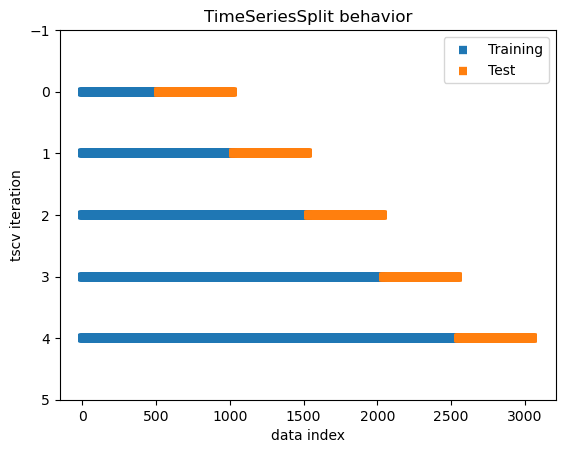

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(tscv.split(X, y)):
    l1 = ax.scatter(tr, [ii] * len(tr), c='tab:blue',
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c='tab:orange',
                    marker='_', lw=6)
ax.set(ylim=[5, -1],
       title='TimeSeriesSplit behavior',
       xlabel='data index', ylabel='tscv iteration')
ax.legend([l1, l2], ['Training', 'Test'])
plt.show()

We'll use grid search with the F1 score as the scoring metric to optimize our models. We'll track its performance across the splits of the time-series cross-validation folds on the trtaining set. Additionally, we will visualize the confusion matrix and note the accuracy and ROC AUC scores for each model on the validation set. Following the construction of the four classifiers outlined below, we will plot ROC curves to further assess their performance.

In [28]:
f1_scorer = 'f1_weighted'

def scores(model, X=X, y=y, X_val=X_val, y_val=y_val):
    f1 = cross_val_score(model, X, y, cv=tscv, scoring='f1_weighted')
    print("Cross validation on training set:")
    print(f"f1 scores: {f1}")
    print(f"mean f1 score: {np.mean(f1)}")
    print(f"standard deviation of f1 scores: {np.std(f1)}", end='\n\n')

    model.fit(X, y)
    preds = model.predict(X_val)

    print("Validation set:")
    print(f"f1 score: {f1_score(y_val, preds)}")
    print(f"accuracy score: {accuracy_score(y_val, preds)}")
    print(f"roc_auc score: {roc_auc_score(y_val, preds)}")

    cm = confusion_matrix(y_val, preds)
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = ['{0:0.0f}'.format(v) for v in cm.flatten()]
    percentages = ['{0:.2%}'.format(v) for v in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    plt.tight_layout()
    plt.show()

### Model 1: Random forest classifier

In [29]:
params = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': range(2, 11, 2),
    'max_depth': range(3, 8)
}

gs = GridSearchCV(RandomForestClassifier(random_state=1),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': range(3, 8),
                         'min_samples_split': range(2, 11, 2),
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [30]:
gs.best_params_

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100}

Cross validation on training set:
f1 scores: [0.61750121 0.56634439 0.64593745 0.62988284 0.59717211]
mean f1 score: 0.6113675995989052
standard deviation of f1 scores: 0.027583004775902174

Validation set:
f1 score: 0.3473053892215569
accuracy score: 0.6437908496732027
roc_auc score: 0.5664860074308893


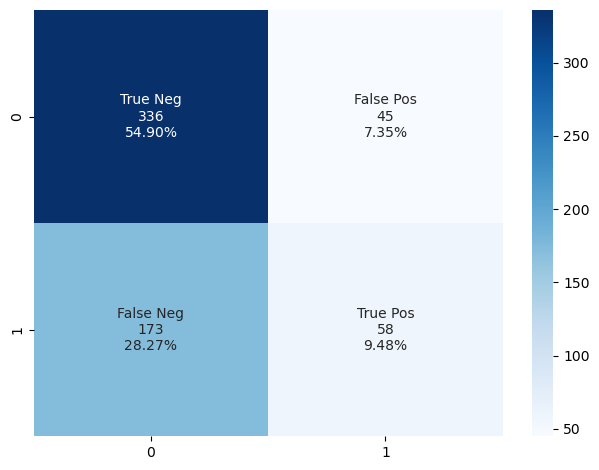

In [31]:
rf = RandomForestClassifier(**gs.best_params_, random_state=1)

scores(rf)

### Model 2: Ridge classifier

In [32]:
params = {
    'alpha': [round(a * 0.1, 1) for a in range(1, 11)]
}

gs = GridSearchCV(RidgeClassifier(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             scoring='f1_weighted')

In [33]:
gs.best_params_

{'alpha': 0.7}

Cross validation on training set:
f1 scores: [0.52372376 0.51663171 0.54302448 0.50628115 0.49858587]
mean f1 score: 0.5176493915388483
standard deviation of f1 scores: 0.01532633991622742

Validation set:
f1 score: 0.1076923076923077
accuracy score: 0.6209150326797386
roc_auc score: 0.5106179909329515


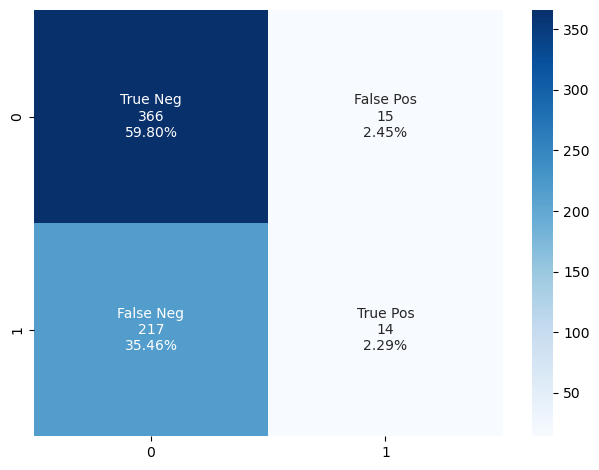

In [34]:
rc = RidgeClassifier(**gs.best_params_)

scores(rc)

### Model 3: Support vector classifier

In [35]:
params = {
    'C': [0.1, 1, 10]
    # kernel = ['linear', 'poly', 'rbf']
}

gs = GridSearchCV(SVC(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(), param_grid={'C': [0.1, 1, 10]},
             scoring='f1_weighted')

In [36]:
gs.best_params_

{'C': 10}

Cross validation on training set:
f1 scores: [0.5055767  0.45932463 0.51482958 0.52222105 0.48413919]
mean f1 score: 0.497218232050348
standard deviation of f1 scores: 0.022856732908554372

Validation set:
f1 score: 0.0
accuracy score: 0.6225490196078431
roc_auc score: 0.5


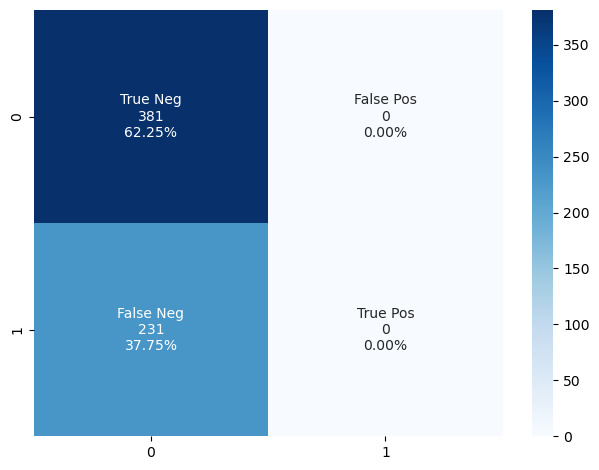

In [37]:
svc = SVC(**gs.best_params_)

scores(svc)

### Model 4: XGBoost Classifier

In [38]:
params = {
    'max_depth': range(3, 8),
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

gs = GridSearchCV(XGBClassifier(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimato

In [39]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross validation on training set:
f1 scores: [0.62853466 0.6358403  0.66565196 0.62083664 0.64221304]
mean f1 score: 0.6386153196525278
standard deviation of f1 scores: 0.015292646837864885

Validation set:
f1 score: 0.4350132625994696
accuracy score: 0.6519607843137255
roc_auc score: 0.5934996761768415


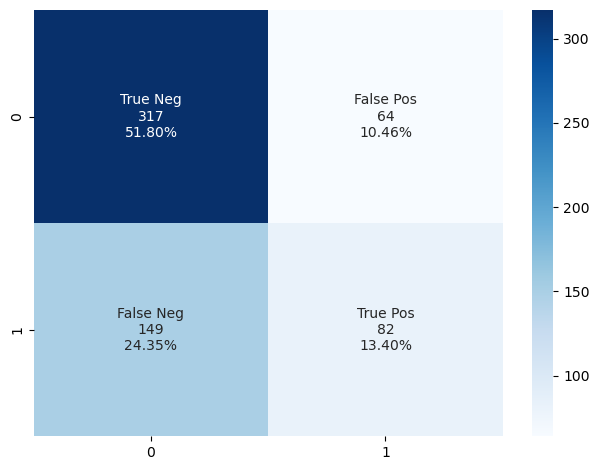

In [40]:
xgbc = XGBClassifier(**gs.best_params_, random_state=1)

scores(xgbc)

### Plotting ROC curves and summary of first models

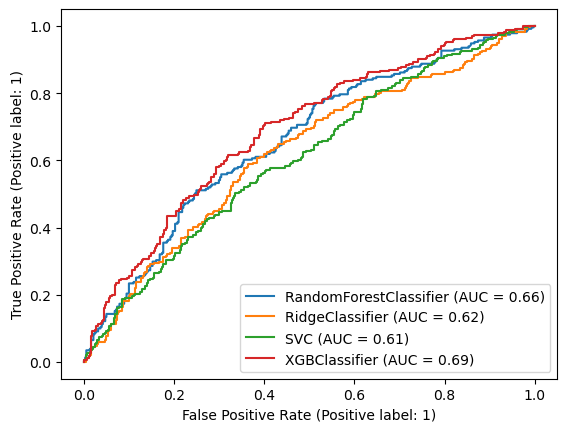

In [41]:
disp = RocCurveDisplay.from_estimator(rf, X_val, y_val)
RocCurveDisplay.from_estimator(rc, X_val, y_val, ax=disp.ax_)
RocCurveDisplay.from_estimator(svc, X_val, y_val, ax=disp.ax_)
RocCurveDisplay.from_estimator(xgbc, X_val, y_val, ax=disp.ax_)
plt.show()

We can see that xgboost classifier performed the best among the models we have built.

Random forest classifier perfomed slightly better than ridge classifier. Looking at the confusion matrix we can see that half of ridge classifier's win predictions are incorrect.

Support vector classifier performed poorly. In the confusion matrix we see that there were no matches where it predicted a win.

In all models, we observe that the scores on the training set are much higher than the scores on the validation set, indicating overfitting.

## Rolling averages and time since last match

In this section, we'll calculate rolling averages of various performance metrics for recent matches in our dataset. We'll also consider the number of days between a match and the team's last match as an additional metric. These features will be incorporated into our model training process.

In [42]:
num_cols = ['sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'sota', 'saves', 'pka',
       'pksv', 'cmp', 'att', 'totdist', 'prgdist', 'live', 'dead', 'tb', 'sw',
       'crs', 'ti', 'ck']

To calculate rolling averages for these metrics, we'll consider the performance of each team in their last three matches. To achieve this, we'll group our dataset by team name and apply a custom function to compute the rolling averages within each group. Our function will also record the number of days since the team's last match.

In [47]:
def rolling_averages(group, cols, mean_cols):
    group = group.sort_values('date')
    group[mean_cols] = group[cols].rolling(3, closed='left').mean()
    group['time_diff'] = group['date'].diff().dt.days
    return group

As an example, let's look at the rolling averages and match day differences of Köln.

In [44]:
group = df.groupby('team_code').get_group(teams_dict['Köln'])

In [45]:
# Name the new columns containing rolling averages
mean_cols = [f"{c}_rolling_mean" for c in num_cols]

In [48]:
rolling_averages(group, num_cols, mean_cols)

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,team_code,hour,day_code,sh_rolling_mean,sot_rolling_mean,dist_rolling_mean,fk_rolling_mean,pk_rolling_mean,pkatt_rolling_mean,sota_rolling_mean,saves_rolling_mean,pka_rolling_mean,pksv_rolling_mean,cmp_rolling_mean,att_rolling_mean,totdist_rolling_mean,prgdist_rolling_mean,live_rolling_mean,dead_rolling_mean,tb_rolling_mean,sw_rolling_mean,crs_rolling_mean,ti_rolling_mean,ck_rolling_mean,time_diff
17,2017-08-20,18:00,Matchweek 1,Sun,Away,L,0,1,Monchengladbach,1.1,1.5,47.0,Matthias Lehmann,4-2-3-1,Deniz Aytekin,13.0,2.0,14.0,1.0,0.0,0.0,8.0,7.0,0.0,0.0,445.0,542.0,8393.0,3129.0,490.0,49.0,0.0,2.0,14.0,21.0,3.0,2017-2018,Köln,0,0,16,14,18,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,2017-08-25,20:30,Matchweek 2,Fri,Home,L,1,3,Hamburger SV,2.1,1.5,70.0,Matthias Lehmann,4-4-2,Felix Brych,20.0,6.0,20.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,499.0,619.0,9604.0,3186.0,563.0,50.0,0.0,4.0,30.0,21.0,6.0,2017-2018,Köln,0,1,10,14,20,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
47,2017-09-09,15:30,Matchweek 3,Sat,Away,L,0,3,Augsburg,0.7,2.3,66.0,Matthias Lehmann,4-4-2,Tobias Stieler,13.0,3.0,19.3,0.0,0.0,0.0,4.0,1.0,1.0,0.0,476.0,605.0,9265.0,3755.0,533.0,71.0,0.0,5.0,30.0,35.0,9.0,2017-2018,Köln,0,0,1,14,15,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
71,2017-09-17,18:00,Matchweek 4,Sun,Away,L,0,5,Dortmund,0.7,3.5,27.0,Matthias Lehmann,4-1-4-1,Patrick Ittrich,6.0,2.0,18.9,1.0,0.0,0.0,8.0,3.0,1.0,0.0,198.0,297.0,3684.0,1807.0,240.0,52.0,0.0,3.0,8.0,19.0,5.0,2017-2018,Köln,0,0,5,14,18,6,15.333333,3.666667,17.766667,0.333333,0.000000,0.000000,5.333333,3.000000,0.333333,0.0,473.333333,588.666667,9087.333333,3356.666667,528.666667,56.666667,0.000000,3.666667,24.666667,25.666667,6.000000,8.0
81,2017-09-20,18:30,Matchweek 5,Wed,Home,L,0,1,Eintracht Frankfurt,2.1,1.2,55.0,Matthias Lehmann,4-4-2,Martin Petersen,17.0,7.0,18.6,1.0,0.0,0.0,4.0,3.0,1.0,0.0,391.0,533.0,6841.0,2640.0,473.0,58.0,0.0,3.0,28.0,23.0,4.0,2017-2018,Köln,0,1,7,14,18,2,13.000000,3.666667,19.400000,0.333333,0.000000,0.000000,5.333333,1.666667,0.666667,0.0,391.000000,507.000000,7517.666667,2916.000000,445.333333,57.666667,0.000000,4.000000,22.666667,25.000000,6.666667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,2023-04-29,15:30,Matchweek 30,Sat,Home,L,0,1,Freiburg,1.6,1.6,57.0,Jonas Hector,4-2-3-1,Tobias Reichel,19.0,4.0,16.9,0.0,0.0,0.0,6.0,5.0,0.0,0.0,387.0,523.0,7280.0,2704.0,470.0,52.0,5.0,2.0,40.0,29.0,9.0,2022-2023,Köln,0,1,8,14,15,5,11.333333,5.000000,17.300000,0.000000,0.333333,0.333333,2.000000,1.000000,0.000000,0.0,332.333333,470.333333,6090.000000,2493.333333,417.666667,48.666667,0.333333,1.666667,17.000000,22.666667,3.000000,7.0
3602,2023-05-05,20:30,Matchweek 31,Fri,Away,W,2,1,Bayer Leverkusen,0.8,0.9,36.0,Jonas Hector,4-2-3-1,Felix Zwayer,7.0,5.0,18.7,0.0,0.0,0.0,3.0,2.0,0.0,0.0,295.0,412.0,5361.0,1989.0,369.0,43.0,1.0,1.0,12.0,22.0,2.0,2022-2023,Köln,1,0,2,14,20,4,14.000000,4.333333,17.766667,0.000000,0.333333,0.333333,3.666667,2.666667,0.000000,0.0,353.000000,489.333333,6544.000000,2592.666667,435.666667,52.000000,1.666667,1.666667,24.666667,25.000000,5.666667,6.0
3618,2023-05-12,20:30,Matchweek 32,Fri,Home,W,5,2,Hertha BSC,4.3,1.1,63.0,Jonas Hector,4-2-3-1,Sven Jablonski,31.0,16.0,13.1,0.0,0.0,0.0,3.0,1.0,0.0,0.0,466.0,574.0,8311.0,2888.0,516.0,58.0,0.0,1.0,37.0,23.0,12.0,2022-2023,Köln,1,1,12,14,20,4,12.666667,4.666667,18.200000,0.000000,0.333333,0.333333,4.333333,3.333333,0.000000,0.0,333.66

Next we'll apply this function to all teams in our data set.

In [49]:
df_roll = df.copy().groupby('team_code') \
    .apply(lambda g: rolling_averages(g, num_cols, mean_cols))

df_roll

date   time         round  day venue result  gf  ga  \
team_code                                                                  
0         1845 2020-09-19  15:30   Matchweek 1  Sat  Away      D   1   1   
          1864 2020-09-26  15:30   Matchweek 2  Sat  Home      W   1   0   
          1881 2020-10-03  15:30   Matchweek 3  Sat  Away      L   0   1   
          1901 2020-10-17  18:30   Matchweek 4  Sat  Home      L   1   4   
          1921 2020-10-25  15:30   Matchweek 5  Sun  Away      L   1   2   
...                   ...    ...           ...  ...   ...    ...  ..  ..   
24        3598 2023-04-30  17:30  Matchweek 30  Sun  Home      W   3   0   
          3617 2023-05-07  17:30  Matchweek 31  Sun  Away      L   0   6   
          3624 2023-05-13  15:30  Matchweek 32  Sat  Home      W   2   1   
          3637 2023-05-19  20:30  Matchweek 33  Fri  Away      L   0   2   
          3661 2023-05-27  15:30  Matchweek 34  Sat  Home      L   1   2   

                           opponent   xg  xga  poss            captain  \
team_code                                                                
0         1845  Eintracht Frankfurt  0.8  2.3  38.0        Fabian Klos   
          1864                 Köln  0.2  1.4  47.0        Fabian Klos   
          1881        Werder Bremen  1.1  0.4  62.0        Fabian Klos   
          1901        Bayern Munich  1.4  3.1  34.0        Fabian Klos   
          1921            Wolfsburg  0.5  2.2  52.0        Fabian Klos   
...                             ...  ...  ...   ...                ...   
24        3598             Mainz 05  1.9  1.7  51.0  Maximilian Arnold   
          3617             Dortmund  1.2  4.2  43.0  Maximilian Arnold   
          3624           Hoffenheim  1.1  1.0  46.0  Maximilian Arnold   
          3637             Freiburg  0.7  1.3  57.0  Maximilian Arnold   
          3661           Hertha BSC  3.4  2.1  64.0  Josuha Guilavogui   

               formation          referee    sh  sot  dist   fk   pk  pkatt  \
team_code                                                                     
0         1845   4-1-4-1   Benjamin Brand  12.0  4.0  22.3  0.0  0.0    0.0   
          1864     4-3-3  Patrick Ittrich   7.0  2.0  26.3  0.0  0.0    0.0   
          1881   4-2-3-1  Robert Schröder   9.0  4.0  18.1  0.0  0.0    0.0   
          1901   4-2-3-1   Daniel Siebert  11.0  5.0  19.8  1.0  0.0    0.0   
          1921   4-2-3-1     Manuel Gräfe   9.0  1.0  23.8  1.0  0.0    0.0   
...                  ...              ...   ...  ...   ...  ...  ...    ...   
24        3598     3-4-3   Daniel Siebert  10.0  4.0  12.1  0.0  0.0    0.0   
          3617   3-1-4-2      Marco Fritz  10.0  3.0  18.5  0.0  0.0    0.0   
          3624   3-1-4-2   Tobias Stieler   9.0  3.0  20.5  0.0  0.0    0.0   
          3637   3-1-4-2  Bastian Dankert   9.0  2.0  18.0  0.0  0.0    0.0   
          3661     3-5-2  Benjamin Cortus  20.0  7.0  12.6  0.0  0.0    0.0   

                sota  saves  pka  pksv    cmp    att  totdist  prgdist   live  \
team_code                                                                       
0         1845   6.0    5.0  0.0   0.0  250.0  366.0   5457.0   2664.0  319.0   
          1864   2.0    2.0  0.0   0.0  361.0  456.0   7723.0   2893.0  398.0   
          1881   2.0    1.0  0.0   0.0  496.0  606.0   9976.0   3510.0  556.0   
          1901   9.0    5.0  0.0   0.0  291.0  385.0   5666.0   2286.0  335.0   
          1921   4.0    2.0  0.0   0.0  454.0  591.0   8572.0   2930.0  530.0   
...              ...    ...  ...   ...    ...    ...      ...      ...    ...   
24        3598   2.0    2.0  0.0   0.0  410.0  526.0   7747.0   2910.0  477.0   
          3617  10.0    4.0  0.0   0.0  321.0  392.0   6478.0   2465.0  346.0   
          3624   2.0    2.0  0.0   0.0  314.0  421.0   6237.0   2662.0  369.0   
          3637   7.0    5.0  0.0   0.0  415.0  515.0   7386.0   2608.0  465.0   
          3661   5.0    3.0  0.0   0.0  502.0  606.0   9917.0   3288.

In [50]:
df_roll = df_roll.droplevel('team_code')

df_roll

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,team_code,hour,day_code,sh_rolling_mean,sot_rolling_mean,dist_rolling_mean,fk_rolling_mean,pk_rolling_mean,pkatt_rolling_mean,sota_rolling_mean,saves_rolling_mean,pka_rolling_mean,pksv_rolling_mean,cmp_rolling_mean,att_rolling_mean,totdist_rolling_mean,prgdist_rolling_mean,live_rolling_mean,dead_rolling_mean,tb_rolling_mean,sw_rolling_mean,crs_rolling_mean,ti_rolling_mean,ck_rolling_mean,time_diff
1845,2020-09-19,15:30,Matchweek 1,Sat,Away,D,1,1,Eintracht Frankfurt,0.8,2.3,38.0,Fabian Klos,4-1-4-1,Benjamin Brand,12.0,4.0,22.3,0.0,0.0,0.0,6.0,5.0,0.0,0.0,250.0,366.0,5457.0,2664.0,319.0,46.0,2.0,5.0,12.0,16.0,3.0,2020-2021,Arminia,0,0,7,0,15,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,2020-09-26,15:30,Matchweek 2,Sat,Home,W,1,0,Köln,0.2,1.4,47.0,Fabian Klos,4-3-3,Patrick Ittrich,7.0,2.0,26.3,0.0,0.0,0.0,2.0,2.0,0.0,0.0,361.0,456.0,7723.0,2893.0,398.0,57.0,1.0,7.0,18.0,31.0,4.0,2020-2021,Arminia,1,1,14,0,15,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1881,2020-10-03,15:30,Matchweek 3,Sat,Away,L,0,1,Werder Bremen,1.1,0.4,62.0,Fabian Klos,4-2-3-1,Robert Schröder,9.0,4.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,496.0,606.0,9976.0,3510.0,556.0,48.0,0.0,6.0,11.0,21.0,1.0,2020-2021,Arminia,0,0,23,0,15,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1901,2020-10-17,18:30,Matchweek 4,Sat,Home,L,1,4,Bayern Munich,1.4,3.1,34.0,Fabian Klos,4-2-3-1,Daniel Siebert,11.0,5.0,19.8,1.0,0.0,0.0,9.0,5.0,0.0,0.0,291.0,385.0,5666.0,2286.0,335.0,48.0,3.0,5.0,12.0,23.0,6.0,2020-2021,Arminia,0,1,3,0,18,5,9.333333,3.333333,22.233333,0.000000,0.0,0.000000,3.333333,2.666667,0.0,0.0,369.000000,476.000000,7718.666667,3022.333333,424.333333,50.333333,1.000000,6.000000,13.666667,22.666667,2.666667,14.0
1921,2020-10-25,15:30,Matchweek 5,Sun,Away,L,1,2,Wolfsburg,0.5,2.2,52.0,Fabian Klos,4-2-3-1,Manuel Gräfe,9.0,1.0,23.8,1.0,0.0,0.0,4.0,2.0,0.0,0.0,454.0,591.0,8572.0,2930.0,530.0,60.0,0.0,10.0,18.0,37.0,3.0,2020-2021,Arminia,0,0,24,0,15,6,9.000000,3.666667,21.400000,0.333333,0.0,0.000000,4.333333,2.666667,0.0,0.0,382.666667,482.333333,7788.333333,2896.333333,429.666667,51.000000,1.333333,6.000000,13.666667,25.000000,3.666667,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,2023-04-30,17:30,Matchweek 30,Sun,Home,W,3,0,Mainz 05,1.9,1.7,51.0,Maximilian Arnold,3-4-3,Daniel Siebert,10.0,4.0,12.1,0.0,0.0,0.0,2.0,2.0,0.0,0.0,410.0,526.0,7747.0,2910.0,477.0,47.0,4.0,2.0,9.0,19.0,3.0,2022-2023,Wolfsburg,1,1,15,24,17,6,11.666667,4.000000,17.266667,0.000000,0.0,0.333333,5.333333,4.333333,0.0,0.0,349.333333,439.000000,6579.666667,2571.666667,391.333333,46.666667,2.000000,3.000000,16.000000,17.666667,4.333333,8.0
3617,2023-05-07,17:30,Matchweek 31,Sun,Away,L,0,6,Dortmund,1.2,4.2,43.0,Maximilian Arnold,3-1-4-2,Marco Fritz,10.0,3.0,18.5,0.0,0.0,0.0,10.0,4.0,0.0,0.0,321.0,392.0,6478.0,2465.0,346.0,44.0,0.0,7.0,15.0,9.0,6.0,2022-2023,Wolfsburg,0,0,5,24,17,6,11.666667,4.666667,15.500000,0.000000,0.0,0.333333,4.000000,3.666667,0.0,0.0,344.666667,438.000000,6536.000000,2581.333333,393.000000,44.000000,3.000000,2.333333,9.000000,16.666667,2.666667,7.0
3624,2023-05-13,15:30,Matchweek 32,Sat,Home,W,2,1,Hoffenheim,1.1,1.0,46.0,Maximilian Arnold,3-1-4-2,Tobias Stieler,9.0,3.0,20.5,0.0,0.0,0.0,2.0,2.0,0.0,0.0,314.0,421.0,6237.0,2662.0,369.0,52.0,1.0,5.0,15.0,25.0,1.0,2022-2023,Wolfsburg,1,1,13,24,15,5,11.333333,4.666667,15.200000,0.000000,0.0,0.333333,6.000000,3.666667,0.0,0.0,324.666667,416.333333,6296.333333,2504.00000

Given that we compute rolling averages based on the last matches, we anticipate encountering null values for the new columns. To prepare our dataset for modeling, we'll remove rows with null values.

Considering that each of the 25 teams loses 3 rows, we expect our dataset to contain 3594 rows after the removal process (originally 3669 rows).

In [51]:
df_roll.dropna(subset=(mean_cols + ['time_diff']), inplace=True)

df_roll

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,team_code,hour,day_code,sh_rolling_mean,sot_rolling_mean,dist_rolling_mean,fk_rolling_mean,pk_rolling_mean,pkatt_rolling_mean,sota_rolling_mean,saves_rolling_mean,pka_rolling_mean,pksv_rolling_mean,cmp_rolling_mean,att_rolling_mean,totdist_rolling_mean,prgdist_rolling_mean,live_rolling_mean,dead_rolling_mean,tb_rolling_mean,sw_rolling_mean,crs_rolling_mean,ti_rolling_mean,ck_rolling_mean,time_diff
1901,2020-10-17,18:30,Matchweek 4,Sat,Home,L,1,4,Bayern Munich,1.4,3.1,34.0,Fabian Klos,4-2-3-1,Daniel Siebert,11.0,5.0,19.8,1.0,0.0,0.0,9.0,5.0,0.0,0.0,291.0,385.0,5666.0,2286.0,335.0,48.0,3.0,5.0,12.0,23.0,6.0,2020-2021,Arminia,0,1,3,0,18,5,9.333333,3.333333,22.233333,0.000000,0.0,0.000000,3.333333,2.666667,0.000000,0.0,369.000000,476.000000,7718.666667,3022.333333,424.333333,50.333333,1.000000,6.000000,13.666667,22.666667,2.666667,14.0
1921,2020-10-25,15:30,Matchweek 5,Sun,Away,L,1,2,Wolfsburg,0.5,2.2,52.0,Fabian Klos,4-2-3-1,Manuel Gräfe,9.0,1.0,23.8,1.0,0.0,0.0,4.0,2.0,0.0,0.0,454.0,591.0,8572.0,2930.0,530.0,60.0,0.0,10.0,18.0,37.0,3.0,2020-2021,Arminia,0,0,24,0,15,6,9.000000,3.666667,21.400000,0.333333,0.0,0.000000,4.333333,2.666667,0.000000,0.0,382.666667,482.333333,7788.333333,2896.333333,429.666667,51.000000,1.333333,6.000000,13.666667,25.000000,3.666667,8.0
1933,2020-10-31,15:30,Matchweek 6,Sat,Home,L,0,2,Dortmund,0.3,2.4,25.0,Fabian Klos,5-3-2,Bastian Dankert,5.0,2.0,19.9,0.0,0.0,0.0,10.0,8.0,0.0,0.0,201.0,300.0,4363.0,2050.0,255.0,44.0,0.0,4.0,6.0,14.0,0.0,2020-2021,Arminia,0,1,5,0,15,5,9.666667,3.333333,20.566667,0.666667,0.0,0.000000,5.000000,2.666667,0.000000,0.0,413.666667,527.333333,8071.333333,2908.666667,473.666667,52.000000,1.000000,7.000000,13.666667,27.000000,3.333333,6.0
1954,2020-11-07,15:30,Matchweek 7,Sat,Away,L,0,5,Union Berlin,0.3,2.0,49.0,Fabian Klos,4-2-3-1,Matthias Jöllenbeck,6.0,1.0,20.1,1.0,0.0,0.0,9.0,4.0,1.0,0.0,470.0,559.0,8529.0,2324.0,505.0,53.0,0.0,2.0,12.0,25.0,1.0,2020-2021,Arminia,0,0,22,0,15,5,8.333333,2.666667,21.166667,0.666667,0.0,0.000000,7.666667,5.000000,0.000000,0.0,315.333333,425.333333,6200.333333,2422.000000,373.333333,50.666667,1.000000,6.333333,12.000000,24.666667,3.000000,7.0
1990,2020-11-28,15:30,Matchweek 9,Sat,Away,L,1,2,RB Leipzig,1.6,2.5,42.0,Fabian Klos,4-2-3-1,Robert Hartmann,14.0,3.0,15.9,0.0,0.0,0.0,6.0,3.0,0.0,1.0,311.0,447.0,6300.0,2623.0,394.0,52.0,0.0,3.0,17.0,22.0,7.0,2020-2021,Arminia,0,0,19,0,15,5,6.666667,1.333333,21.266667,0.666667,0.0,0.000000,7.666667,4.666667,0.333333,0.0,375.000000,483.333333,7154.666667,2434.666667,430.000000,52.333333,0.000000,5.333333,12.000000,25.333333,1.333333,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,2023-04-30,17:30,Matchweek 30,Sun,Home,W,3,0,Mainz 05,1.9,1.7,51.0,Maximilian Arnold,3-4-3,Daniel Siebert,10.0,4.0,12.1,0.0,0.0,0.0,2.0,2.0,0.0,0.0,410.0,526.0,7747.0,2910.0,477.0,47.0,4.0,2.0,9.0,19.0,3.0,2022-2023,Wolfsburg,1,1,15,24,17,6,11.666667,4.000000,17.266667,0.000000,0.0,0.333333,5.333333,4.333333,0.000000,0.0,349.333333,439.000000,6579.666667,2571.666667,391.333333,46.666667,2.000000,3.000000,16.000000,17.666667,4.333333,8.0
3617,2023-05-07,17:30,Matchweek 31,Sun,Away,L,0,6,Dortmund,1.2,4.2,43.0,Maximilian Arnold,3-1-4-2,Marco Fritz,10.0,3.0,18.5,0.0,0.0,0.0,10.0,4.0,0.0,0.0,321.0,392.0,6478.0,2465.0,346.0,44.0,0.0,7.0,15.0,9.0,6.0,2022-2023,Wolfsburg,0,0,5,24,17,6,11.666667,4.666667,15.500000,0.000000,0.0,0.333333,4.000000,3.666667,0.000000,0.0,344.666667,438.000000,6536.000000,2581.333333,393.000000,44.000000,3.000000,2.333333,9.000000,16.666667,2.666667,7.0
3624,2023-05-13,15

We are now ready to finalize our set of predictors and incorporate them into our training set accordingly.

In [52]:
roll_predictors = predictors + mean_cols + ['time_diff']

In [53]:
train = df_roll[df_roll['date'] < '2022-07-01']
val = df_roll[df_roll['date'] > '2022-07-01']

X_roll = train[roll_predictors]
y_roll = train['target']

X_val_roll = val[roll_predictors]
y_val_roll = val['target']

We will revisit the same four models, following the steps outlined previously.

### Model 1: Random forest classifier (with rolling averages)

In [54]:
params = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': range(2, 11, 2),
    'max_depth': range(3, 8)
}

gs = GridSearchCV(RandomForestClassifier(random_state=1),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X_roll, y_roll)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': range(3, 8),
                         'min_samples_split': range(2, 11, 2),
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [55]:
gs.best_params_

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200}

Cross validation on training set:
f1 scores: [0.58253637 0.60204239 0.54691637 0.54962221 0.55045452]
mean f1 score: 0.5663143738733084
standard deviation of f1 scores: 0.02211827202288613

Validation set:
f1 score: 0.2693602693602693
accuracy score: 0.6454248366013072
roc_auc score: 0.55245935167195


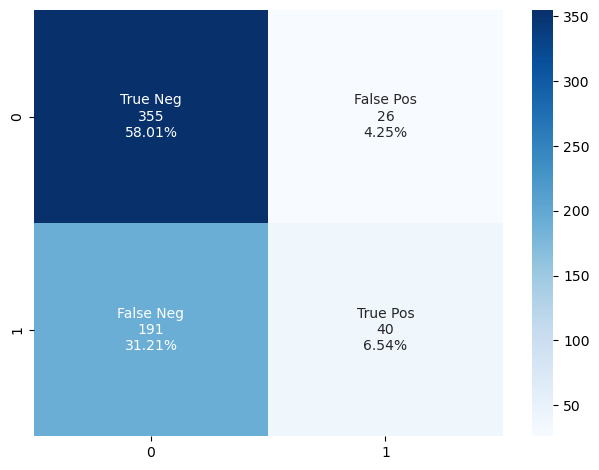

In [56]:
rf_roll = RandomForestClassifier(**gs.best_params_, random_state=1)

scores(rf_roll, X=X_roll, X_val=X_val_roll, y=y_roll, y_val=y_val_roll)

### Model 2: Ridge classifier (with rolling averages)

In [57]:
params = {
    'alpha': [round(a * 0.1, 1) for a in range(1, 11)]
}

gs = GridSearchCV(RidgeClassifier(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X_roll, y_roll)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             scoring='f1_weighted')

In [58]:
gs.best_params_

{'alpha': 0.1}

Cross validation on training set:
f1 scores: [0.3219196  0.64289417 0.58196716 0.57059759 0.55203847]
mean f1 score: 0.5338833989829654
standard deviation of f1 scores: 0.11027382752519102

Validation set:
f1 score: 0.3710144927536232
accuracy score: 0.6454248366013072
roc_auc score: 0.572911340627876


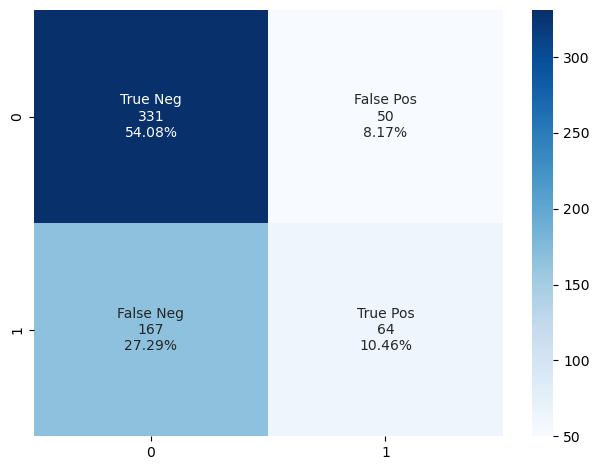

In [59]:
rc_roll = RidgeClassifier(**gs.best_params_)

scores(rc_roll, X=X_roll, X_val=X_val_roll, y=y_roll, y_val=y_val_roll)

### Model 3: Support vector classifier (with rolling averages)

In [60]:
params = {
    'C': [0.1, 1, 10]
    # kernel = ['linear', 'poly', 'rbf']
}

gs = GridSearchCV(SVC(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X_roll, y_roll)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(), param_grid={'C': [0.1, 1, 10]},
             scoring='f1_weighted')

In [61]:
gs.best_params_

{'C': 10}

Cross validation on training set:
f1 scores: [0.61848879 0.59447376 0.5450677  0.50706006 0.52796781]
mean f1 score: 0.5586116243521225
standard deviation of f1 scores: 0.041596664953147525

Validation set:
f1 score: 0.09523809523809525
accuracy score: 0.6274509803921569
roc_auc score: 0.5141630023519788


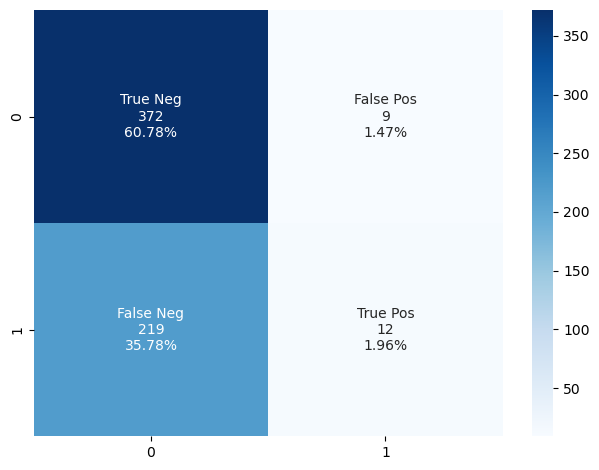

In [62]:
svc_roll = SVC(**gs.best_params_)

scores(svc_roll, X=X_roll, X_val=X_val_roll, y=y_roll, y_val=y_val_roll)

### Model 4: XGBoost Classifier (with rolling averages)

In [63]:
params = {
    'max_depth': range(3, 8),
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

gs = GridSearchCV(XGBClassifier(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X_roll, y_roll)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimato

In [64]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

Cross validation on training set:
f1 scores: [0.5013372  0.62739283 0.59987794 0.59545777 0.58846182]
mean f1 score: 0.5825055107238765
standard deviation of f1 scores: 0.042680689948306524

Validation set:
f1 score: 0.4329896907216495
accuracy score: 0.6405228758169934
roc_auc score: 0.5860176568837987


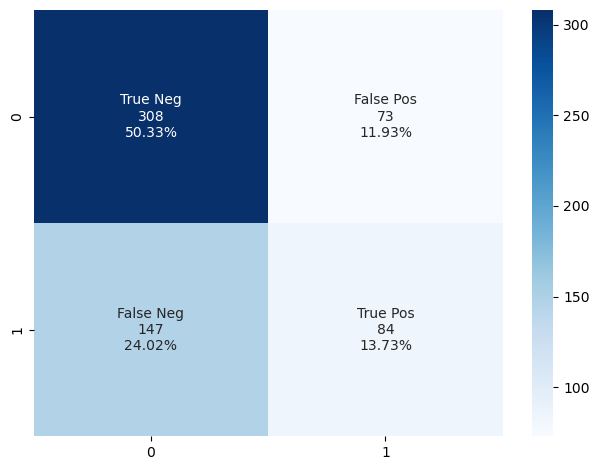

In [65]:
xgbc_roll = XGBClassifier(**gs.best_params_, random_state=1)

scores(xgbc_roll, X=X_roll, X_val=X_val_roll, y=y_roll, y_val=y_val_roll)

### Plotting ROC curves and summary of models with rolling averages

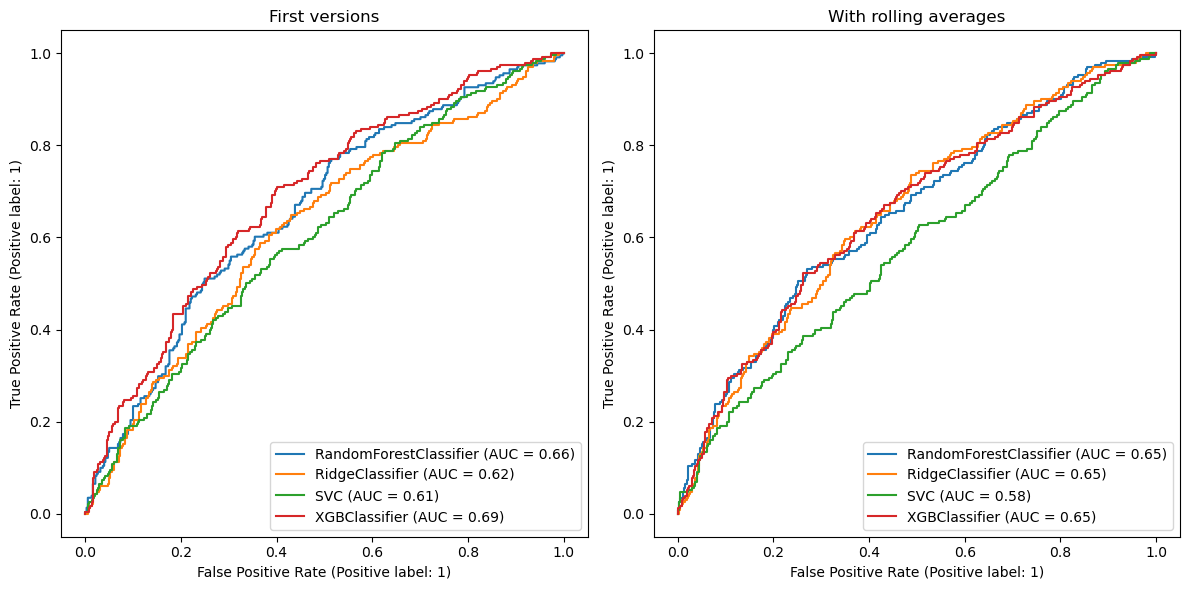

In [66]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)

disp1 = RocCurveDisplay.from_estimator(rf, X_val, y_val, ax=ax1)
RocCurveDisplay.from_estimator(rc, X_val, y_val, ax=disp1.ax_)
RocCurveDisplay.from_estimator(svc, X_val, y_val, ax=disp1.ax_)
RocCurveDisplay.from_estimator(xgbc, X_val, y_val, ax=disp1.ax_)
plt.title("First versions")

ax2 = plt.subplot(1, 2, 2)

disp2 = RocCurveDisplay.from_estimator(rf_roll, X_val_roll, y_val_roll, ax=ax2)
RocCurveDisplay.from_estimator(rc_roll, X_val_roll, y_val_roll, ax=disp2.ax_)
RocCurveDisplay.from_estimator(svc_roll, X_val_roll, y_val_roll, ax=disp2.ax_)
RocCurveDisplay.from_estimator(xgbc_roll, X_val_roll, y_val_roll, ax=disp2.ax_)
plt.title("With rolling averages")

plt.tight_layout()
plt.show()

We observe that adding rolling averages of performance metrics has negatively impacted most models, but improved the performance of the ridge classifier.

The scores we document for the training and validation sets suggest overfitting in all of our models. It seems that especially for the random forest and xgboost classifiers, rolling averages have introduced redundant information, and these models have memorized patterns that do not generalize well to unseen data.

Since ridge regression inherently penalizes overly complex models, it seems this model managed to benefit from the additional rolling averages data.

## Conclusion

In summary, the xgboost classifier achieved the best results for match score prediction using only team, opponent, venue, day and hour data. This suggests these basic features hold significant predictive power.